In [1]:
import pandas as pd
import numpy as np
import os
import re
from math import ceil, floor, log10, sqrt, trunc, modf
import sympy as sy
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import allantools
from typing import NamedTuple
from datetime import datetime, timedelta
import copy
from scipy import optimize, integrate
from ftplib import FTP, error_perm
from io import BytesIO
from allantools import oadev
import matplotlib.pyplot as plt

In [2]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/'

In [3]:
def mjd_now():
    """
    Convert a date to Modified Julian Day.

    Algorithm sourced from 'Practical Astronomy with your Calculator or Spreadsheet',
        4th ed., Duffet-Smith and Zwart, 2011.

    Parameters
    ----------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.

    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.

    day : float
        Day, may contain fractional part.

    Returns
    -------
    mjd : float
        Modified Julian Day

    """
   
    year, month, day, h, m, s = datetime.now().year, datetime.now().month, datetime.now().day, datetime.now().hour, datetime.now().minute, datetime.now().second,
   
    if month == 1 or month == 2:  # months rescaled so february is last month of the year because 28 days
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month

    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
            (year == 1582 and month < 10) or
            (year == 1582 and month == 10 and day < 15)):
        # before start of Gregorian calendar
        print('Time must be later than October 1582')
        raise SystemExit

    # after start of Gregorian calendar
    a = trunc(yearp / 100.)  # discount leap years falling on a multiple of 100
    b = 2 - a + trunc(a / 4.)  # recount leap years falling on a multiple of 400

    c = trunc(365.25 * yearp)

    d = trunc(30.6001 * (monthp + 1))

    jd = b + c + d + day + 1720994.5  # Integer is julian day for 2 B.C. Oct 30
    jd += h/24 + m/1440 + s/86400

    return jd - 2400000.5

def date_to_mjd(year, month, day):
    """
    Convert a date to Modified Julian Day.

    Algorithm sourced from 'Practical Astronomy with your Calculator or Spreadsheet',
        4th ed., Duffet-Smith and Zwart, 2011.

    Parameters
    ----------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.

    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.

    day : float
        Day, may contain fractional part.

    Returns
    -------
    mjd : float
        Modified Julian Day

    """
    if month == 1 or month == 2:  # months rescaled so february is last month of the year because 28 days
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month

    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
            (year == 1582 and month < 10) or
            (year == 1582 and month == 10 and day < 15)):
        # before start of Gregorian calendar
        print('Time must be later than October 1582')
        raise SystemExit

    # after start of Gregorian calendar
    a = trunc(yearp / 100.)  # discount leap years falling on a multiple of 100
    b = 2 - a + trunc(a / 4.)  # recount leap years falling on a multiple of 400

    c = trunc(365.25 * yearp)

    d = trunc(30.6001 * (monthp + 1))

    jd = b + c + d + day + 1720994.5  # Integer is julian day for 2 B.C. Oct 30

    return jd - 2400000.5


def mjd_to_date(mjd):
    """
    Convert Modified Julian Day to date.

    Algorithm from 'Practical Astronomy with your Calculator or Spreadsheet',
        4th ed., Duffet-Smith and Zwart, 2011.

    Parameters
    ----------
    mjd : float
        Julian Day

    Returns
    -------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.

    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.

    day : float
        Day, may contain fractional part.
    """
    jd = mjd + 2400001

    F, I = modf(jd)
    I = int(I)

    A = trunc((I - 1867216.25) / 36524.25)

    if I > 2299160:
        B = I + 1 + A - trunc(A / 4.)
    else:
        B = I

    C = B + 1524

    D = trunc((C - 122.1) / 365.25)

    E = trunc(365.25 * D)

    G = trunc((C - E) / 30.6001)

    day = C - E + F - trunc(30.6001 * G)

    if G < 13.5:
        month = G - 1
    else:
        month = G - 13

    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715

    month = '{:02}'.format(month)

    return year, month, day

def fountain_stats(HD_data, LD_data, HD_adev, LD_adev):
    """
     Returns
    -------
    f0 : float - zero-density fountain frequency
    uA_diff: uncertainty on the freq diff betwwen high and low density
    uA_f0: statistical uncertainty on f0
    uB_f0: systematic uncertainty on collisional shift
    uA_HD/uA_LD: statistical uncertainty of the high-density mean fractional frequency difference,
           excluding dead time effects. It is given by the successive-point Allan deviation of the high-density
           measurements divided by the square root of the number of high density points in the time window
    fHD/fLD: average fractional frequency difference for data set
    """

    if len(HD_data):
        fHD = HD_data['Frequency Error'].mean()
        nHD = HD_data['Shot A Sum'].mean()
        uA_HD = HD_adev / sqrt(len(HD_data.dropna()))
    else:
        fHD, nHD, uA_HD = np.nan, np.nan, np.nan

    if len(LD_data):
        fLD = LD_data['Frequency Error'].mean()
        nLD = LD_data['Shot A Sum'].mean()
        uA_LD = LD_adev / sqrt(len(LD_data.dropna()))
    else:
        fLD, nLD, uA_LD = np.nan, np.nan, np.nan
       

    uA_diff = sqrt(uA_HD ** 2 + uA_LD ** 2)

    f0 = fLD - (nLD * ((fHD - fLD) / (nHD - nLD))) # exptrapolate to zero density
   
   
    uA_f0 = sqrt((uA_HD * (nLD / (nHD - nLD))) ** 2 + (uA_LD * (1 + (nLD / (nHD - nLD)))) ** 2)

    uB_f0 = 0.1 * ((nHD * nLD) / ((nHD - nLD) ** 2)) * sqrt((fHD - fLD) ** 2 + uA_diff ** 2)

    return [f0 / 9192631770, uA_f0, uB_f0 / 9192631770, uA_diff, uA_HD,
                              uA_LD, fHD / 9192631770, fLD / 9192631770]


def overlapping_allan_dev(data, rate=0.3):
    max_tau = np.log10(len(data) / 0.6)
    taus = np.logspace(0, max_tau, 40)
    y = np.array(data.dropna())  # Prepare the frequency data
    allan_tuple = allantools.oadev(y, rate=rate, data_type="freq", taus=taus)  # Get overlapping ADEV
    return allan_tuple

def add_error_quadrature(err1, err2):  # Takes floats and returns the quadrature as a scientific string
    tot = np.sqrt(float(err1) ** 2 + float(err2) ** 2)
    return np.format_float_scientific(tot, precision=3, trim='0')

def fountain_hourly_write(HD, LD, start_date_mjd, end_date_mjd):
    def find_deadtimes(h_data, h):
        # Make list of deadtime ranges in seconds from start of bin paired in tuples
        seconds = h_data['Seconds'].astype(int)
        start_index = np.flatnonzero(np.diff(seconds) > 5)
        end_index = start_index + 1

        dead_start = seconds.iloc[start_index]
        dead_end = seconds.iloc[end_index]
        dead_times = list(zip(dead_start, dead_end))

        dead_times = [(h*3600, seconds.iloc[0])] + dead_times
        dead_times = dead_times + [(seconds.iloc[-1], (h+1)*3600)]
        return dead_times

    data = []
    start = modf(float(start_date_mjd))
    end = modf(float(end_date_mjd))
    start_hour = ceil(start[0] / (1/24))
    end_hour = floor(end[0] / (1/24))

    start_calendar = mjd_to_date(start[1])  # type: tuple(int, int, float)
    end_calendar = mjd_to_date(end[1])  # type: tuple(int, int, float)

    start_string = f'{start_calendar[0]}-{start_calendar[1]}-{trunc(start_calendar[2])}T{start_hour:02}:00:00Z'
    end_string = f'{end_calendar[0]}-{end_calendar[1]}-{trunc(end_calendar[2])}T{end_hour:02}:00:00Z'

    DATE_TIME_STRING_FORMAT = '%Y-%m-%dT%H:%M:%SZ'

    from_date_time = datetime.strptime(start_string, DATE_TIME_STRING_FORMAT)
    to_date_time = datetime.strptime(end_string, DATE_TIME_STRING_FORMAT)

    date_times = []
    while from_date_time < to_date_time:
        date_times.append(from_date_time.strftime(DATE_TIME_STRING_FORMAT))
        from_date_time += timedelta(hours=1)


    for date_string in date_times:
        day = int(date_to_mjd(int(date_string[0:4]), int(date_string[5:7]), int(date_string[8:10])))
        hour = int(date_string[11:13])
        fountain_data, successive_adev, deadtimes = [], [], []
        for full_data in HD, LD:
            hourly_data = full_data.loc[(full_data['MJD Days'] == day)].copy(deep=False)
            hourly_data = hourly_data[hourly_data["Seconds"].between((hour * 3600) + 1, (hour + 1) * 3600)]
            if len(hourly_data) > 1:
                (t2, ad, ade, adn) = overlapping_allan_dev(hourly_data['Frequency Error'])
                successive_adev.append(ad[0] / 9192631770)  # Cs hyperfine transition
                deadtimes.append(find_deadtimes(hourly_data, hour))
            else:
                deadtimes.append([(0 + (hour * 3600), (hour + 1) * 3600)])
                successive_adev.append(np.nan)
            fountain_data.append(hourly_data)
        hourly_stats = fountain_stats(fountain_data[0], fountain_data[1],
                                      successive_adev[0], successive_adev[1])
       
        uB_tot = add_error_quadrature(2E-16, hourly_stats[2])

        data.append({'Bin Start UTC': date_string, 'Bin Start MJD Days': day, 'Bin Start Seconds':
                        hour * 3600, 'Bin End MJD Days': day, 'Bin End Seconds': (hour * 3600) + 3599,
                     'f0': hourly_stats[0], 'uA (f0)': hourly_stats[1], 'uB (f0)': float(uB_tot),
                     'Freq Diff (LD-HD)': hourly_stats[7] - hourly_stats[6],
                     'uA (LD-HD)': hourly_stats[3], 'HD Freq': hourly_stats[6],
                     'uA (HD)': hourly_stats[4], 'LD Freq': hourly_stats[7], 'uA (LD)': hourly_stats[5],
                     'Mean HD Signal (Vs)': fountain_data[0]['Shot A Sum'].mean(),
                     'uA (HD Sig)': fountain_data[0]['Shot A Sum'].sem(),
                     'Mean LD Signal (Vs)': fountain_data[1]['Shot A Sum'].mean(),
                     'uA (LD Sig)': fountain_data[1]['Shot A Sum'].sem(),
                     'No. of HD Points': len(fountain_data[0].dropna()),
                     'No. of LD Points': len(fountain_data[1].dropna()),
                     'HD Deadtimes': deadtimes[0], 'LD Deadtimes': deadtimes[1]})
    hourly_bins = pd.DataFrame.from_dict(data)
   
    return(hourly_bins)

def get_recent_frequencies(systematic_shift=4.485e-14, past_days = 15, HD_low = 30, HD_high = 90, LD_low = 4, LD_high = 15, stD = 5):
   
    #find all LD and HD file in directory
    datafiles = os.listdir(save_dir +'Alpha_CSF_up_to_date')

    LD_files = []
    HD_files = []
    for i in datafiles:
        if(i.split()[0]=='ALPHA-CsF1'):
            if(int(float(i.split()[3])) > mjd_now() - past_days and bool(i.split()[4])):
                if i.split()[6] == 'LD.txt':
                    LD_files.append(i)
                elif i.split()[6] == 'HD.txt':
                    HD_files.append(i)

    #read in files
    HD_dfs = []  
    LD_dfs = []

    for file in HD_files:

        HD_dfs.append(pd.read_csv(save_dir +'Alpha_CSF_up_to_date/' + file , comment='%', delim_whitespace=True, header=None, usecols=[*range(0, 5)],
                                   names=['MJD Days', 'Seconds', 'Frequency Error', 'Shot A Sum', 'Shot A Ratio'],
                                   dtype={'MJD Days': 'float', 'Seconds': 'float', 'Frequency Error': 'float',
                                             'Shot A Sum': 'float', 'Shot A Ratio': 'float'}))

    for file in LD_files:
        LD_dfs.append(pd.read_csv(save_dir +'Alpha_CSF_up_to_date/' + file , comment='%', delim_whitespace=True, header=None, usecols=[*range(0, 5)],
                                   names=['MJD Days', 'Seconds', 'Frequency Error', 'Shot A Sum', 'Shot A Ratio'],
                                   dtype={'MJD Days': 'float', 'Seconds': 'float', 'Frequency Error': 'float',
                                             'Shot A Sum': 'float', 'Shot A Ratio': 'float'}))
    #concentate and reset index
    HD = pd.concat(HD_dfs).reset_index()
    LD = pd.concat(LD_dfs).reset_index()

    #drops NaN's and set datatypes
    HD = HD.dropna()
    HD.astype({'MJD Days': 'int32', 'Seconds': 'int32'}).dtypes
    LD = LD.dropna()
    LD.astype({'MJD Days': 'int32', 'Seconds': 'int32'}).dtypes
   
    #remove exceedingly low and high sum values
    HD = HD[1000*HD['Shot A Sum']>HD_low]
    HD = HD[1000*HD['Shot A Sum']<HD_high]
    LD = LD[1000*LD['Shot A Sum']>LD_low]
    LD = LD[1000*LD['Shot A Sum']<LD_high]
   
    #set LD >5 SD bounds
    LD['upper bound'] = LD['Frequency Error'].rolling(150, center=True).mean() + stD*LD['Frequency Error'].rolling(150, center=True).std()
    LD['lower bound'] = LD['Frequency Error'].rolling(150, center=True).mean() - stD*LD['Frequency Error'].rolling(150, center=True).std()
    LD.loc[0:74, 'upper bound'] = LD[75:76]['upper bound'].values[0]
    LD.loc[LD.index[-1]-73:,'upper bound'] = LD[-75:-74]['upper bound'].values[0]
    LD.loc[0:74, 'lower bound'] = LD[75:76]['lower bound'].values[0]
    LD.loc[LD.index[-1]-73:,'lower bound'] = LD[-75:-74]['lower bound'].values[0]
   
    #set HD >5 SD bounds
    HD['upper bound'] = HD['Frequency Error'].rolling(50, center=True).mean() + stD*HD['Frequency Error'].rolling(50, center=True).std()
    HD['lower bound'] = HD['Frequency Error'].rolling(50, center=True).mean() - stD*HD['Frequency Error'].rolling(50, center=True).std()
    HD.loc[0:25, 'upper bound'] = HD[25:26]['upper bound'].values[0]
    HD.loc[HD.index[-1]-23:, 'upper bound'] = HD[-25:-24]['upper bound'].values[0]
    HD.loc[0:25, 'lower bound'] = HD[25:26]['lower bound'].values[0]
    HD.loc[HD.index[-1]-23:,'lower bound'] = HD[-25:-24]['lower bound'].values[0]

   
    #remove values outside those bounds
    LD_clean = LD[LD['Frequency Error']< LD['upper bound']]
    LD_clean = LD_clean[LD_clean['Frequency Error']> LD_clean['lower bound']]
    HD_clean = HD[HD['Frequency Error']< HD['upper bound']]
    HD_clean = HD_clean[HD_clean['Frequency Error']> HD_clean['lower bound']]

    #use LD and HD to get df of final freqeuncies out
    hour_bin_df = fountain_hourly_write(HD_clean, LD_clean, int(mjd_now())-past_days, int(mjd_now())+1)
   
    #add a MJD timestamp
    hour_bin_df['timestamp'] = hour_bin_df['Bin Start MJD Days'].astype(float) + hour_bin_df['Bin Start Seconds'].astype(float)/86400
    #drop missing hours
    hour_bin_df=hour_bin_df.dropna()
    #apply systematic shift
    hour_bin_df['f0'] = hour_bin_df['f0'] - systematic_shift
    return hour_bin_df

In [4]:
X = get_recent_frequencies(past_days=35)

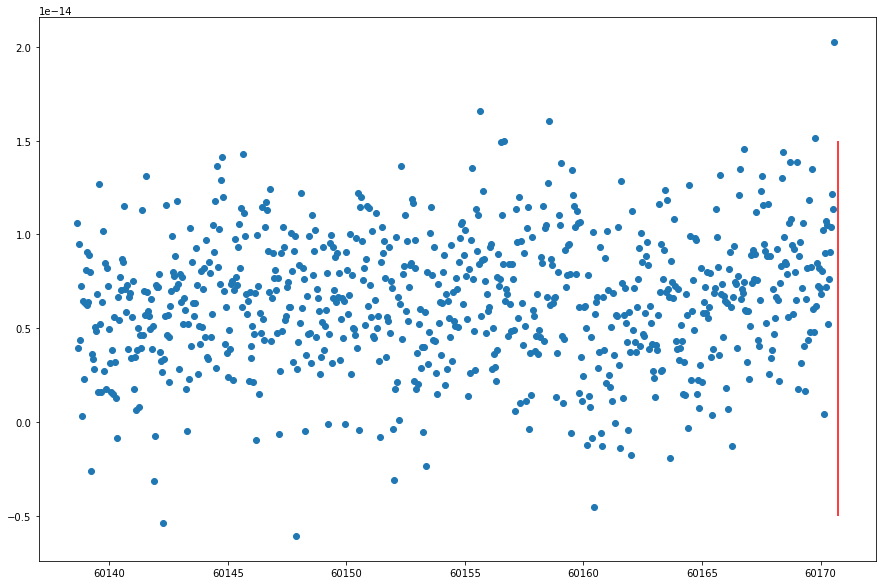

In [5]:
plt.figure(figsize=(15,10))

plt.plot(X['timestamp'],X['f0'],'o')
plt.vlines(mjd_now(),-0.5e-14,1.5e-14,color='r')

In [6]:
X.to_csv(save_dir + "recent_data_30_days_04_08.csv", index=True)